## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs, load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings('ignore')

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Create Synthetic Dataset

First, let me create a synthetic dataset with elliptical clusters to demonstrate GMM's advantages over K-Means.

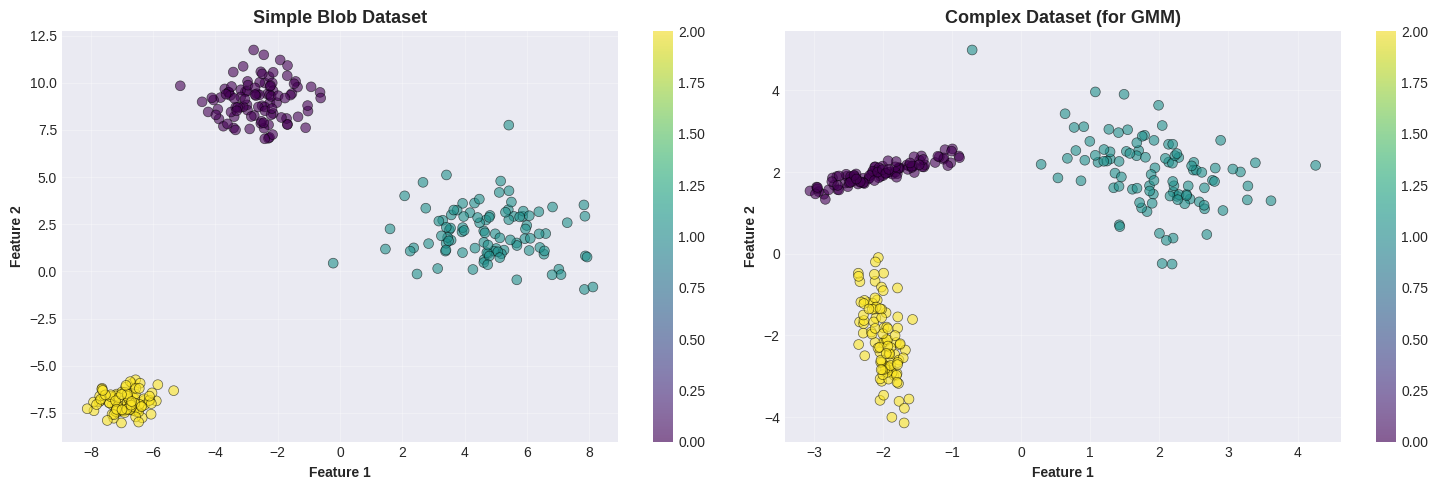

Simple dataset: (300, 2)
Complex dataset: (300, 2)


In [2]:
# Generate synthetic data with different cluster shapes
from sklearn.datasets import make_blobs

# Create blobs with different covariances
n_samples = 300
X_simple, y_simple = make_blobs(n_samples=n_samples, centers=3, n_features=2,
                                cluster_std=[1.0, 1.5, 0.5], random_state=42)

# Create elongated clusters for better GMM demonstration
from sklearn.datasets import make_classification
X_complex, y_complex = make_classification(n_samples=n_samples, n_features=2,
                                           n_informative=2, n_redundant=0,
                                           n_clusters_per_class=1, n_classes=3,
                                           class_sep=2.0, random_state=42)

# Visualize both datasets
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

scatter1 = axes[0].scatter(X_simple[:, 0], X_simple[:, 1], c=y_simple,
                          cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title('Simple Blob Dataset', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Feature 1', fontweight='bold')
axes[0].set_ylabel('Feature 2', fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(X_complex[:, 0], X_complex[:, 1], c=y_complex,
                          cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_title('Complex Dataset (for GMM)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Feature 1', fontweight='bold')
axes[1].set_ylabel('Feature 2', fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"Simple dataset: {X_simple.shape}")
print(f"Complex dataset: {X_complex.shape}")

## 3. Applying Gaussian Mixture Model

Let me fit a GMM to our data and visualize the results, including the covariance ellipses.

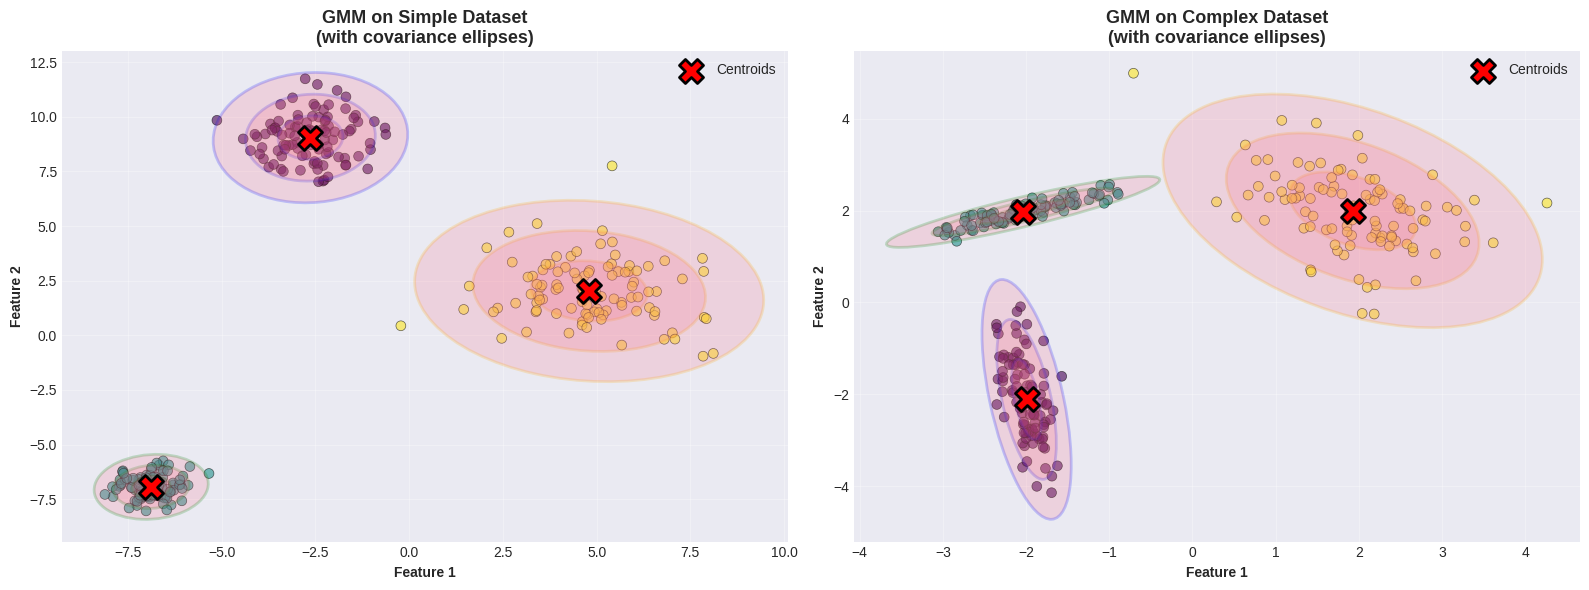


💡 The ellipses show 1σ, 2σ, and 3σ contours of the Gaussian distributions.
Notice how GMM captures the shape and orientation of each cluster!


In [6]:
def draw_ellipse(position, covariance, ax, **kwargs):
    """Draw an ellipse representing a 2D Gaussian distribution."""
    # Convert covariance to principal axes
    if covariance.ndim == 2 and covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    elif covariance.ndim == 0: # Handle scalar covariance for spherical type
        angle = 0
        radius = 2 * np.sqrt(covariance)
        width, height = radius, radius
    else:
        raise ValueError(f"Unsupported covariance shape or dimension: {covariance.shape}, {covariance.ndim}")

    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                            angle=angle, alpha=0.2, **kwargs))

def plot_gmm(gmm, X, y_pred, title, ax):
    """Plot GMM clustering results with covariance ellipses."""
    ax.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis',
              s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

    # Plot cluster centers
    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1],
              marker='X', s=300, c='red', edgecolors='black',
              linewidth=2, label='Centroids', zorder=10)

    # Draw covariance ellipses
    colors = ['blue', 'green', 'orange']
    for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
        draw_ellipse(mean, covar, ax, edgecolor=colors[i], linewidth=2)

    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('Feature 1', fontweight='bold')
    ax.set_ylabel('Feature 2', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Fit GMM to both datasets
gmm_simple = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
y_pred_simple = gmm_simple.fit_predict(X_simple)

gmm_complex = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
y_pred_complex = gmm_complex.fit_predict(X_complex)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_gmm(gmm_simple, X_simple, y_pred_simple,
         'GMM on Simple Dataset\n(with covariance ellipses)', axes[0])
plot_gmm(gmm_complex, X_complex, y_pred_complex,
         'GMM on Complex Dataset\n(with covariance ellipses)', axes[1])

plt.tight_layout()
plt.show()

print("\n💡 The ellipses show 1σ, 2σ, and 3σ contours of the Gaussian distributions.")
print("Notice how GMM captures the shape and orientation of each cluster!")

## 4. Understanding Covariance Types

GMM supports different covariance matrix types. Let me demonstrate the difference:

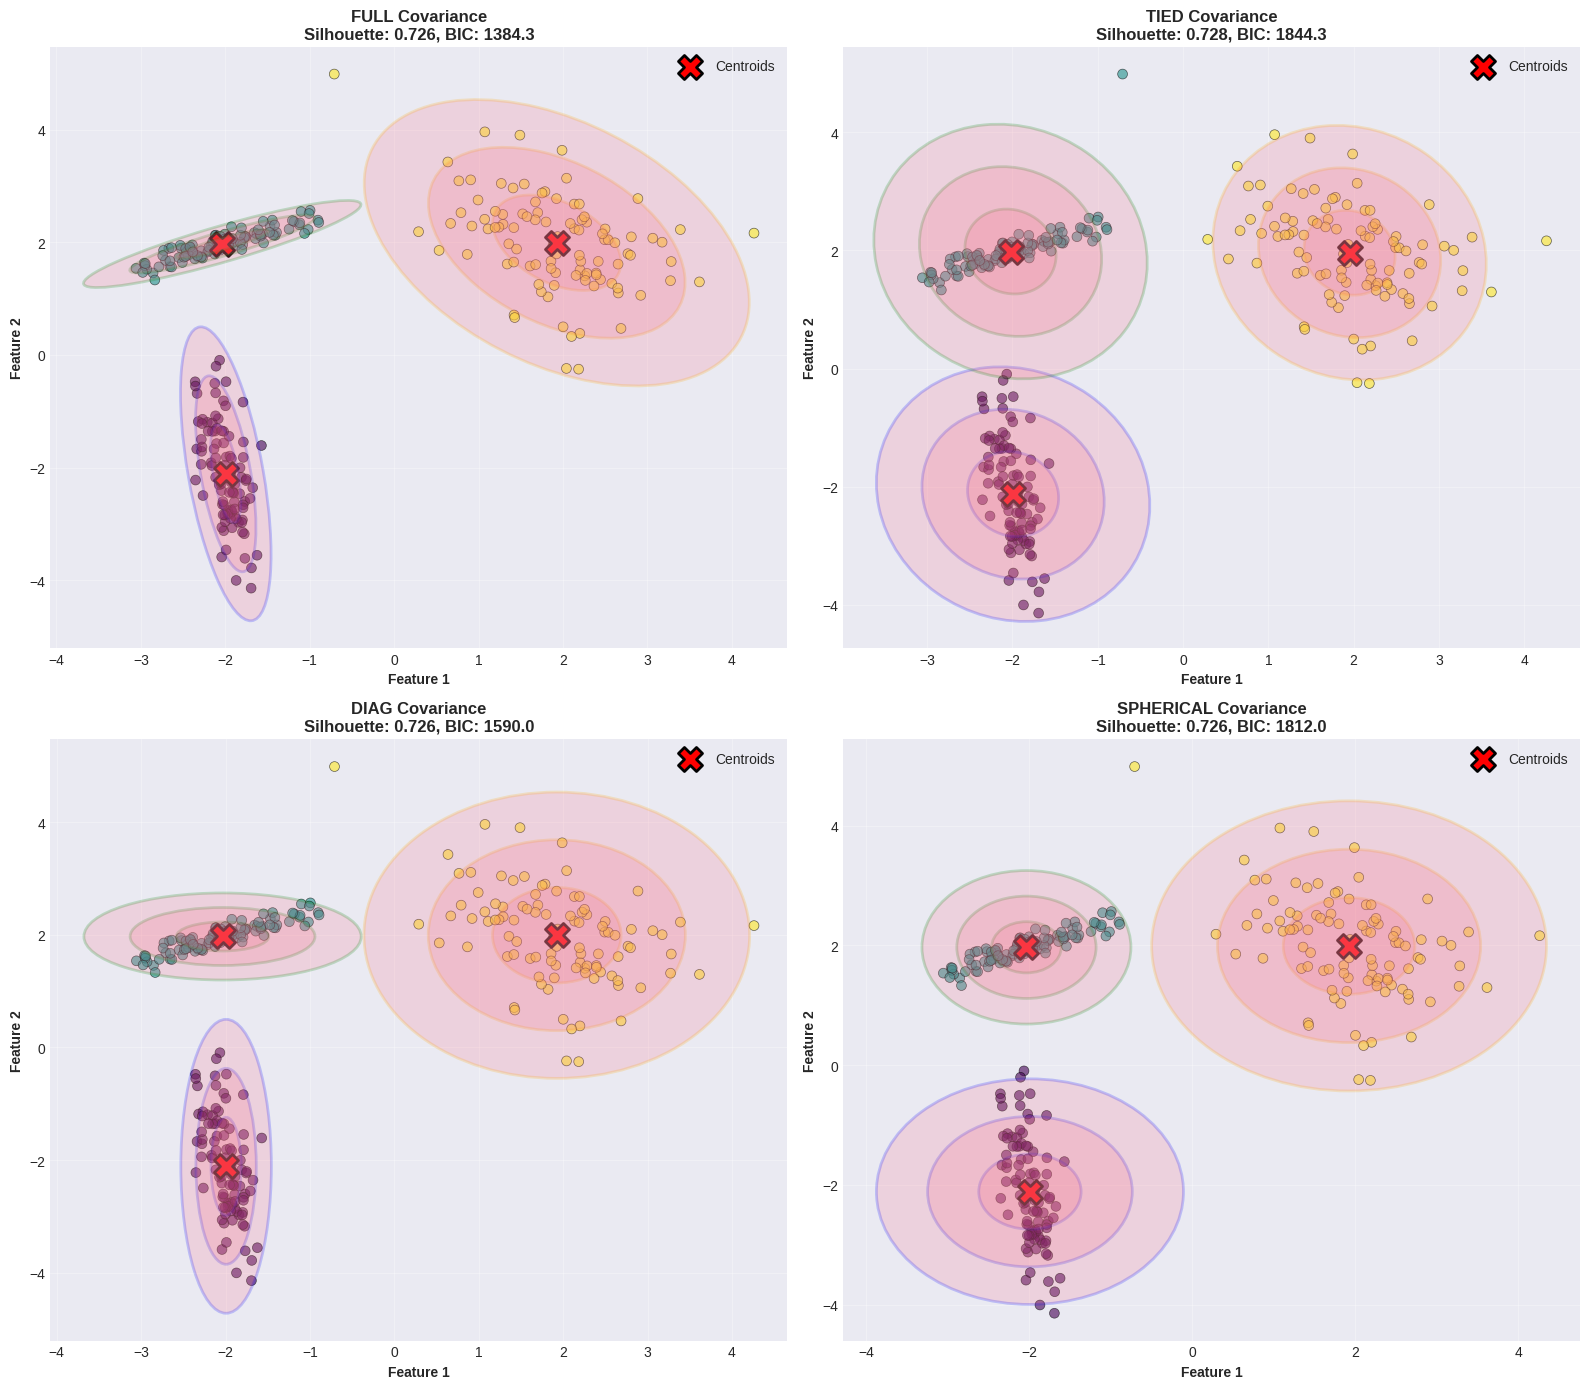


📊 Covariance Types Explained:

1. FULL: Each cluster has its own general covariance matrix
   → Most flexible, can model any ellipse shape and orientation

2. TIED: All clusters share the same covariance matrix
   → Ellipses have same shape/orientation, but different centers

3. DIAG: Diagonal covariance matrix (axes aligned)
   → Ellipses aligned with coordinate axes

4. SPHERICAL: Circular clusters (like K-Means)
   → All clusters are circles, simplest model


In [7]:
covariance_types = ['full', 'tied', 'diag', 'spherical']

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, cov_type in enumerate(covariance_types):
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    y_pred = gmm.fit_predict(X_complex)

    axes[idx].scatter(X_complex[:, 0], X_complex[:, 1], c=y_pred,
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    axes[idx].scatter(gmm.means_[:, 0], gmm.means_[:, 1],
                     marker='X', s=300, c='red', edgecolors='black',
                     linewidth=2, label='Centroids')

    # Draw ellipses
    colors = ['blue', 'green', 'orange']
    if cov_type == 'full':
        for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
            draw_ellipse(mean, covar, axes[idx], edgecolor=colors[i], linewidth=2)
    elif cov_type == 'tied':
        for i, mean in enumerate(gmm.means_):
            draw_ellipse(mean, gmm.covariances_, axes[idx], edgecolor=colors[i], linewidth=2)
    elif cov_type == 'diag':
        for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
            draw_ellipse(mean, np.diag(covar), axes[idx], edgecolor=colors[i], linewidth=2)
    elif cov_type == 'spherical':
        for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
            draw_ellipse(mean, covar, axes[idx], edgecolor=colors[i], linewidth=2)

    # Calculate metrics
    sil_score = silhouette_score(X_complex, y_pred)
    bic = gmm.bic(X_complex)
    aic = gmm.aic(X_complex)

    axes[idx].set_title(f'{cov_type.upper()} Covariance\nSilhouette: {sil_score:.3f}, BIC: {bic:.1f}',
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Feature 1', fontweight='bold')
    axes[idx].set_ylabel('Feature 2', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Covariance Types Explained:\n")
print("1. FULL: Each cluster has its own general covariance matrix")
print("   → Most flexible, can model any ellipse shape and orientation")
print("\n2. TIED: All clusters share the same covariance matrix")
print("   → Ellipses have same shape/orientation, but different centers")
print("\n3. DIAG: Diagonal covariance matrix (axes aligned)")
print("   → Ellipses aligned with coordinate axes")
print("\n4. SPHERICAL: Circular clusters (like K-Means)")
print("   → All clusters are circles, simplest model")

## 5. Model Selection: Finding Optimal Number of Components

One of GMM's big advantages is using BIC (Bayesian Information Criterion) or AIC (Akaike Information Criterion) to choose the optimal number of clusters. Lower values indicate better models.

Testing different numbers of components...

n=2: BIC=1846.90, AIC=1806.15, Silhouette=0.573
n=3: BIC=1384.32, AIC=1321.36, Silhouette=0.726
n=4: BIC=1411.81, AIC=1326.63, Silhouette=0.633
n=5: BIC=1424.35, AIC=1316.94, Silhouette=0.547
n=6: BIC=1449.93, AIC=1320.29, Silhouette=0.545
n=7: BIC=1475.14, AIC=1323.29, Silhouette=0.471
n=8: BIC=1504.05, AIC=1329.98, Silhouette=0.441
n=9: BIC=1533.65, AIC=1337.35, Silhouette=0.383


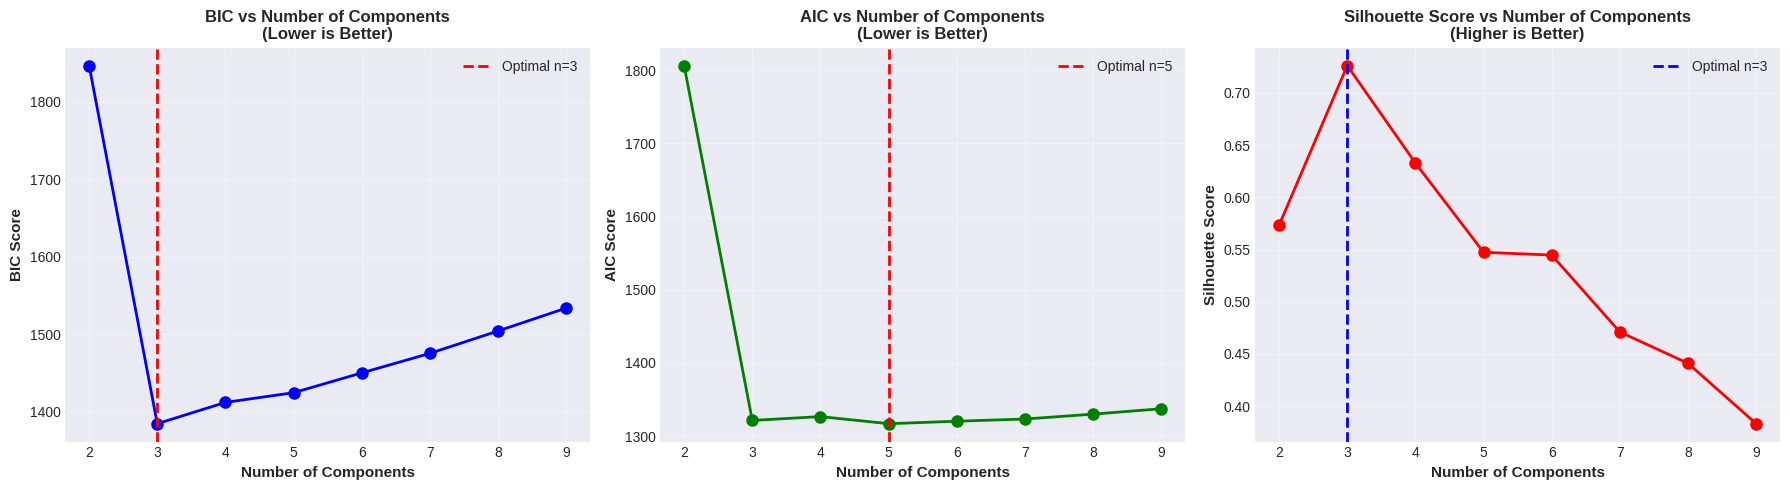


🎯 Optimal number of components:
  According to BIC: 3
  According to AIC: 5
  According to Silhouette: 3


In [8]:
# Test different numbers of components
n_components_range = range(2, 10)
bic_scores = []
aic_scores = []
silhouette_scores = []

print("Testing different numbers of components...\n")

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_complex)
    y_pred = gmm.predict(X_complex)

    bic = gmm.bic(X_complex)
    aic = gmm.aic(X_complex)
    sil = silhouette_score(X_complex, y_pred)

    bic_scores.append(bic)
    aic_scores.append(aic)
    silhouette_scores.append(sil)

    print(f"n={n}: BIC={bic:.2f}, AIC={aic:.2f}, Silhouette={sil:.3f}")

# Plot model selection criteria
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# BIC
axes[0].plot(n_components_range, bic_scores, 'bo-', linewidth=2, markersize=8)
optimal_bic = n_components_range[np.argmin(bic_scores)]
axes[0].axvline(x=optimal_bic, color='r', linestyle='--', linewidth=2,
               label=f'Optimal n={optimal_bic}')
axes[0].set_xlabel('Number of Components', fontsize=11, fontweight='bold')
axes[0].set_ylabel('BIC Score', fontsize=11, fontweight='bold')
axes[0].set_title('BIC vs Number of Components\n(Lower is Better)',
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AIC
axes[1].plot(n_components_range, aic_scores, 'go-', linewidth=2, markersize=8)
optimal_aic = n_components_range[np.argmin(aic_scores)]
axes[1].axvline(x=optimal_aic, color='r', linestyle='--', linewidth=2,
               label=f'Optimal n={optimal_aic}')
axes[1].set_xlabel('Number of Components', fontsize=11, fontweight='bold')
axes[1].set_ylabel('AIC Score', fontsize=11, fontweight='bold')
axes[1].set_title('AIC vs Number of Components\n(Lower is Better)',
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Silhouette
axes[2].plot(n_components_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
optimal_sil = n_components_range[np.argmax(silhouette_scores)]
axes[2].axvline(x=optimal_sil, color='b', linestyle='--', linewidth=2,
               label=f'Optimal n={optimal_sil}')
axes[2].set_xlabel('Number of Components', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[2].set_title('Silhouette Score vs Number of Components\n(Higher is Better)',
                  fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 Optimal number of components:")
print(f"  According to BIC: {optimal_bic}")
print(f"  According to AIC: {optimal_aic}")
print(f"  According to Silhouette: {optimal_sil}")

## 6. Soft vs Hard Clustering

A key feature of GMM is "soft clustering" - each point gets a probability of belonging to each cluster. Let me demonstrate this!

SOFT VS HARD CLUSTERING

Example probabilities for first 5 points:

Point | Cluster 0 | Cluster 1 | Cluster 2 | Hard Assignment
-----------------------------------------------------------------
  0   |   0.000   |   0.000   |   1.000   |      2
  1   |   1.000   |   0.000   |   0.000   |      0
  2   |   1.000   |   0.000   |   0.000   |      0
  3   |   1.000   |   0.000   |   0.000   |      0
  4   |   1.000   |   0.000   |   0.000   |      0


💡 Found 0 uncertain points (max probability < 70%)


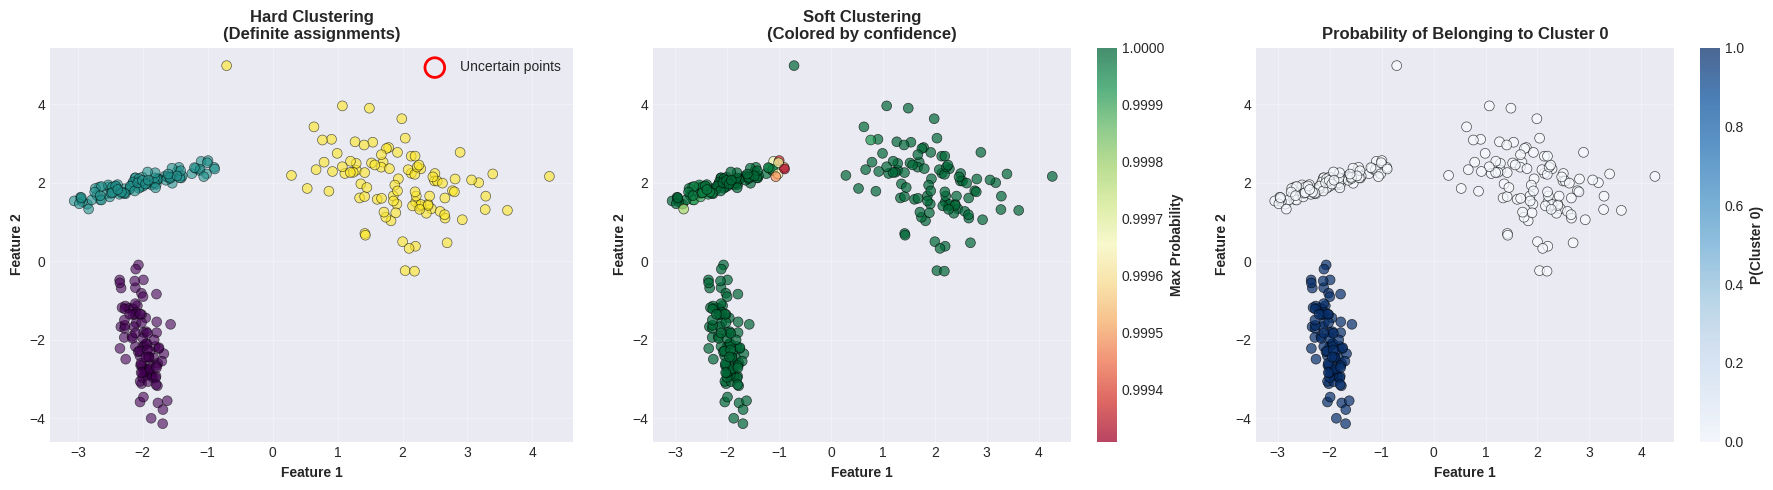


💭 Interpretation:
  • Darker green in middle plot = higher confidence
  • Points near cluster boundaries have lower confidence
  • Red circles show points with high uncertainty
  • Right plot shows probability gradient for one specific cluster


In [9]:
# Fit GMM
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(X_complex)

# Hard clustering (predict)
y_hard = gmm.predict(X_complex)

# Soft clustering (predict_proba)
y_soft = gmm.predict_proba(X_complex)

print("="*70)
print("SOFT VS HARD CLUSTERING")
print("="*70)
print("\nExample probabilities for first 5 points:")
print("\nPoint | Cluster 0 | Cluster 1 | Cluster 2 | Hard Assignment")
print("-" * 65)
for i in range(5):
    print(f"  {i}   |   {y_soft[i, 0]:.3f}   |   {y_soft[i, 1]:.3f}   |   {y_soft[i, 2]:.3f}   |      {y_hard[i]}")

# Find points with high uncertainty (probabilities close to each other)
max_probs = y_soft.max(axis=1)
uncertain_indices = np.where(max_probs < 0.7)[0]  # Points with < 70% certainty

print(f"\n\n💡 Found {len(uncertain_indices)} uncertain points (max probability < 70%)")

# Visualize soft clustering
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hard clustering
axes[0].scatter(X_complex[:, 0], X_complex[:, 1], c=y_hard,
               cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].scatter(X_complex[uncertain_indices, 0], X_complex[uncertain_indices, 1],
               s=200, facecolors='none', edgecolors='red', linewidth=2,
               label='Uncertain points')
axes[0].set_title('Hard Clustering\n(Definite assignments)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Feature 1', fontweight='bold')
axes[0].set_ylabel('Feature 2', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Soft clustering - colored by maximum probability
scatter = axes[1].scatter(X_complex[:, 0], X_complex[:, 1], c=max_probs,
                         cmap='RdYlGn', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_title('Soft Clustering\n(Colored by confidence)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Feature 1', fontweight='bold')
axes[1].set_ylabel('Feature 2', fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Max Probability', fontweight='bold')

# Probability for cluster 0
scatter2 = axes[2].scatter(X_complex[:, 0], X_complex[:, 1], c=y_soft[:, 0],
                          cmap='Blues', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[2].set_title('Probability of Belonging to Cluster 0', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Feature 1', fontweight='bold')
axes[2].set_ylabel('Feature 2', fontweight='bold')
axes[2].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[2])
cbar2.set_label('P(Cluster 0)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💭 Interpretation:")
print("  • Darker green in middle plot = higher confidence")
print("  • Points near cluster boundaries have lower confidence")
print("  • Red circles show points with high uncertainty")
print("  • Right plot shows probability gradient for one specific cluster")

## 7. Real-World Dataset: Breast Cancer

Let me apply GMM to a real dataset - the breast cancer dataset from sklearn.

In [10]:
# Load breast cancer dataset
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target  # 0 = malignant, 1 = benign
feature_names = cancer.feature_names

print("="*70)
print("BREAST CANCER DATASET")
print("="*70)
print(f"Shape: {X_cancer.shape}")
print(f"Features: {len(feature_names)}")
print(f"Samples: {len(X_cancer)}")
print(f"\nClass distribution:")
unique, counts = np.unique(y_cancer, return_counts=True)
for label, count in zip(['Malignant', 'Benign'], counts):
    print(f"  {label}: {count} ({count/len(y_cancer)*100:.1f}%)")
print("="*70)

# Standardize
scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(X_cancer)

print("\n✓ Data standardized")

BREAST CANCER DATASET
Shape: (569, 30)
Features: 30
Samples: 569

Class distribution:
  Malignant: 212 (37.3%)
  Benign: 357 (62.7%)

✓ Data standardized


### Find Optimal Number of Components for Cancer Data

Finding optimal number of components for cancer data...

n=2: BIC=6094.0, AIC=1789.3, Silhouette=0.314
n=3: BIC=6287.7, AIC=-171.6, Silhouette=0.251
n=4: BIC=7248.9, AIC=-1365.1, Silhouette=0.227
n=5: BIC=9130.0, AIC=-1638.5, Silhouette=0.121
n=6: BIC=10468.8, AIC=-2454.3, Silhouette=0.124
n=7: BIC=10703.3, AIC=-4374.3, Silhouette=0.121


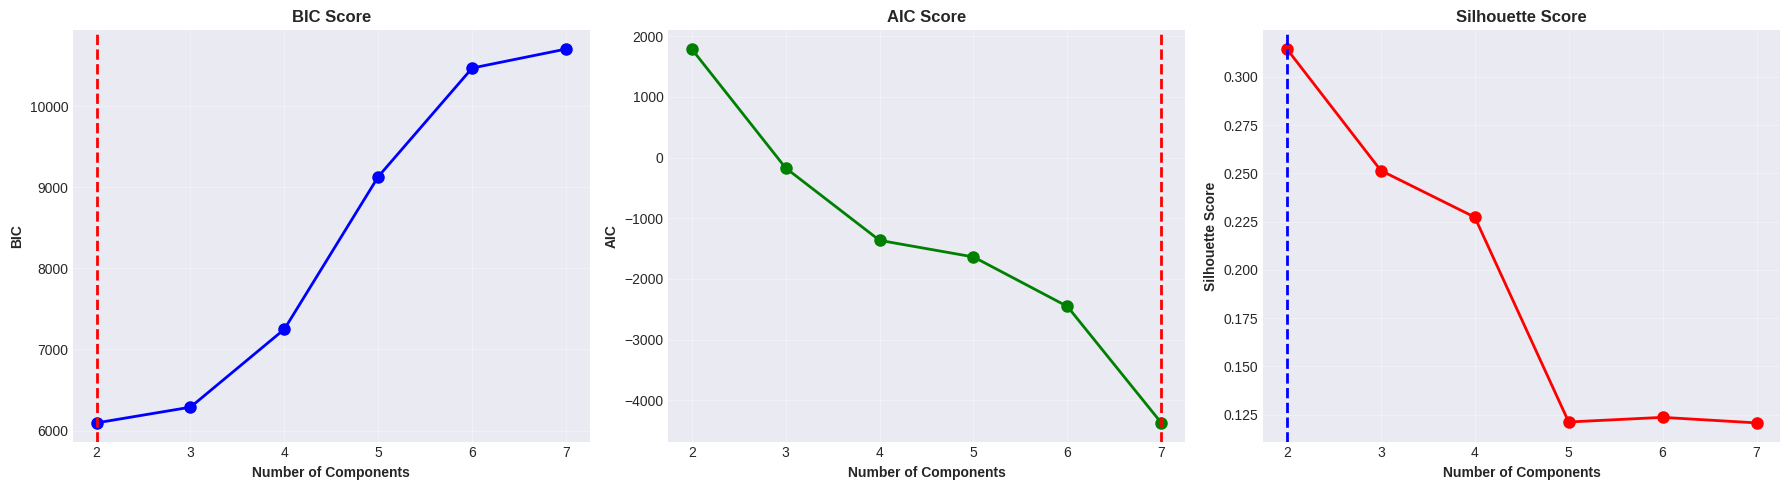


🎯 Optimal number of components: 2


In [11]:
# Test different numbers of components
n_range = range(2, 8)
bic_cancer = []
aic_cancer = []
sil_cancer = []

print("Finding optimal number of components for cancer data...\n")

for n in n_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42, max_iter=200)
    gmm.fit(X_cancer_scaled)
    labels = gmm.predict(X_cancer_scaled)

    bic = gmm.bic(X_cancer_scaled)
    aic = gmm.aic(X_cancer_scaled)
    sil = silhouette_score(X_cancer_scaled, labels)

    bic_cancer.append(bic)
    aic_cancer.append(aic)
    sil_cancer.append(sil)

    print(f"n={n}: BIC={bic:.1f}, AIC={aic:.1f}, Silhouette={sil:.3f}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(n_range, bic_cancer, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(x=n_range[np.argmin(bic_cancer)], color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Number of Components', fontweight='bold')
axes[0].set_ylabel('BIC', fontweight='bold')
axes[0].set_title('BIC Score', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(n_range, aic_cancer, 'go-', linewidth=2, markersize=8)
axes[1].axvline(x=n_range[np.argmin(aic_cancer)], color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Number of Components', fontweight='bold')
axes[1].set_ylabel('AIC', fontweight='bold')
axes[1].set_title('AIC Score', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(n_range, sil_cancer, 'ro-', linewidth=2, markersize=8)
axes[2].axvline(x=n_range[np.argmax(sil_cancer)], color='b', linestyle='--', linewidth=2)
axes[2].set_xlabel('Number of Components', fontweight='bold')
axes[2].set_ylabel('Silhouette Score', fontweight='bold')
axes[2].set_title('Silhouette Score', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_n_cancer = n_range[np.argmin(bic_cancer)]
print(f"\n🎯 Optimal number of components: {optimal_n_cancer}")

### Apply GMM and Evaluate

GMM CLUSTERING RESULTS - BREAST CANCER DATASET

Internal Metrics:
  Silhouette Score:         0.3145
  Davies-Bouldin Index:     1.3770
  Calinski-Harabasz Score:  247.28

External Metrics (vs true labels):
  Adjusted Rand Index:      0.7740
  Normalized Mutual Info:   0.6611

Model Information:
  BIC: 6094.04
  AIC: 1789.25
  Log-likelihood: 0.17
  Converged: True
  Iterations: 8


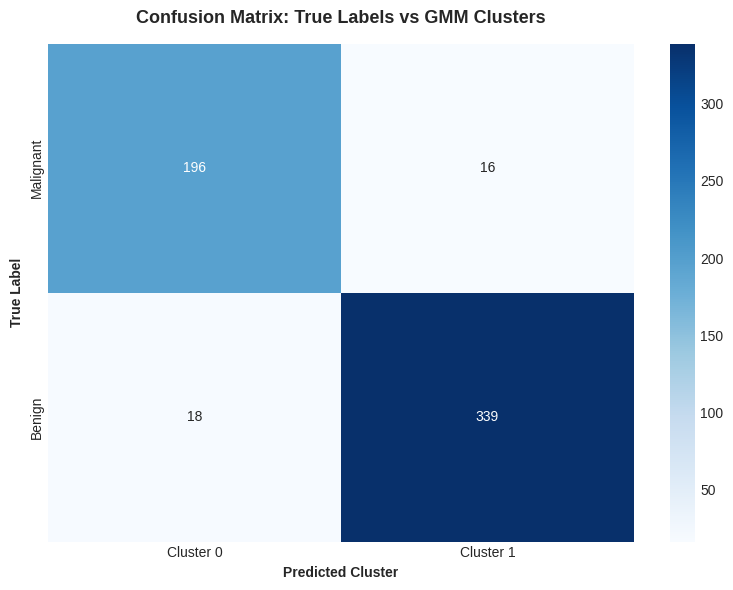

In [12]:
# Fit GMM with 2 components (since we have 2 classes)
gmm_cancer = GaussianMixture(n_components=2, covariance_type='full', random_state=42, max_iter=200)
gmm_cancer.fit(X_cancer_scaled)
y_pred_cancer = gmm_cancer.predict(X_cancer_scaled)
y_proba_cancer = gmm_cancer.predict_proba(X_cancer_scaled)

# Calculate metrics
sil = silhouette_score(X_cancer_scaled, y_pred_cancer)
db = davies_bouldin_score(X_cancer_scaled, y_pred_cancer)
ch = calinski_harabasz_score(X_cancer_scaled, y_pred_cancer)
ari = adjusted_rand_score(y_cancer, y_pred_cancer)
nmi = normalized_mutual_info_score(y_cancer, y_pred_cancer)

print("="*70)
print("GMM CLUSTERING RESULTS - BREAST CANCER DATASET")
print("="*70)
print(f"\nInternal Metrics:")
print(f"  Silhouette Score:         {sil:.4f}")
print(f"  Davies-Bouldin Index:     {db:.4f}")
print(f"  Calinski-Harabasz Score:  {ch:.2f}")
print(f"\nExternal Metrics (vs true labels):")
print(f"  Adjusted Rand Index:      {ari:.4f}")
print(f"  Normalized Mutual Info:   {nmi:.4f}")
print(f"\nModel Information:")
print(f"  BIC: {gmm_cancer.bic(X_cancer_scaled):.2f}")
print(f"  AIC: {gmm_cancer.aic(X_cancer_scaled):.2f}")
print(f"  Log-likelihood: {gmm_cancer.score(X_cancer_scaled):.2f}")
print(f"  Converged: {gmm_cancer.converged_}")
print(f"  Iterations: {gmm_cancer.n_iter_}")
print("="*70)

# Confusion matrix
cm = confusion_matrix(y_cancer, y_pred_cancer)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['Malignant', 'Benign'])
plt.title('Confusion Matrix: True Labels vs GMM Clusters',
          fontsize=13, fontweight='bold', pad=15)
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Cluster', fontweight='bold')
plt.tight_layout()
plt.show()

### Visualize with PCA

PCA Explained Variance: 63.24%


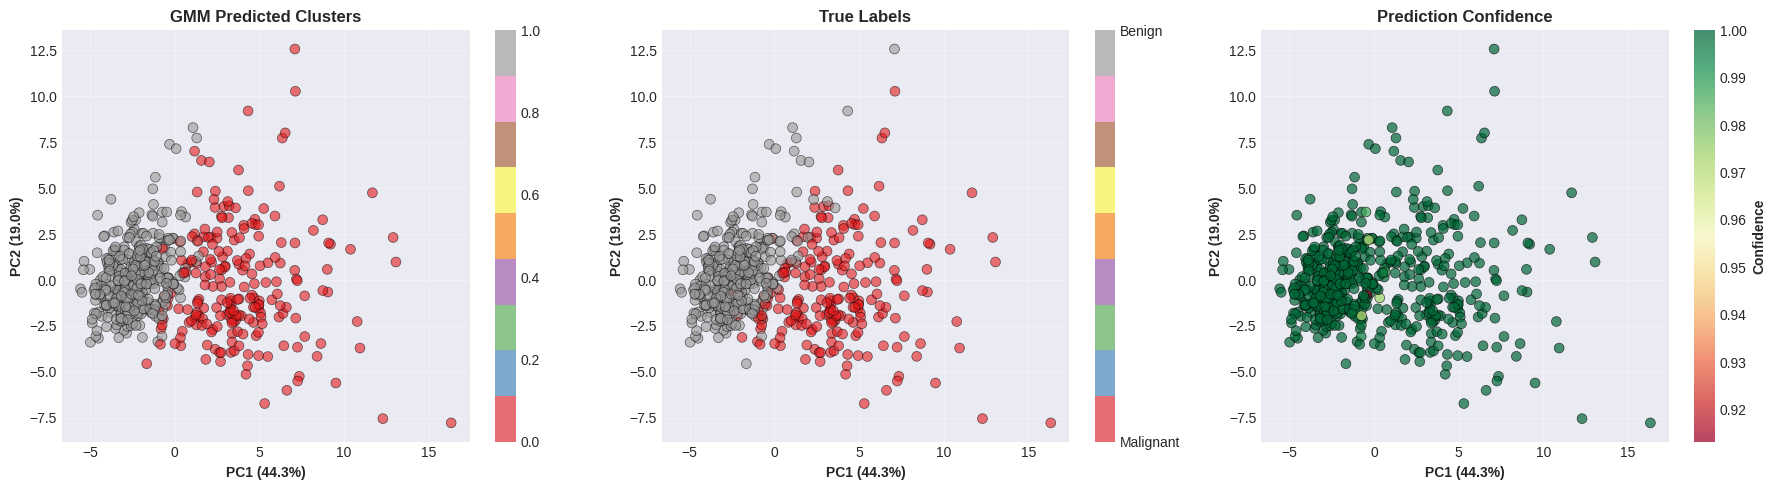

In [13]:
# PCA for visualization
pca = PCA(n_components=2)
X_cancer_pca = pca.fit_transform(X_cancer_scaled)

print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")

# Get confidence levels
confidence = y_proba_cancer.max(axis=1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predicted clusters
scatter1 = axes[0].scatter(X_cancer_pca[:, 0], X_cancer_pca[:, 1],
                          c=y_pred_cancer, cmap='Set1',
                          s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title('GMM Predicted Clusters', fontsize=12, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0])

# True labels
scatter2 = axes[1].scatter(X_cancer_pca[:, 0], X_cancer_pca[:, 1],
                          c=y_cancer, cmap='Set1',
                          s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_title('True Labels', fontsize=12, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontweight='bold')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['Malignant', 'Benign'])

# Confidence
scatter3 = axes[2].scatter(X_cancer_pca[:, 0], X_cancer_pca[:, 1],
                          c=confidence, cmap='RdYlGn',
                          s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[2].set_title('Prediction Confidence', fontsize=12, fontweight='bold')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontweight='bold')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontweight='bold')
axes[2].grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=axes[2])
cbar3.set_label('Confidence', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. GMM vs K-Means Comparison

Let me directly compare GMM with K-Means on our datasets.

GMM VS K-MEANS COMPARISON - BREAST CANCER DATASET


,Algorithm,Silhouette,Davies-Bouldin,ARI,NMI
0,GMM (full cov),0.314489,1.377034,0.774016,0.661057
1,K-Means,0.343382,1.320510,0.653625,0.532408


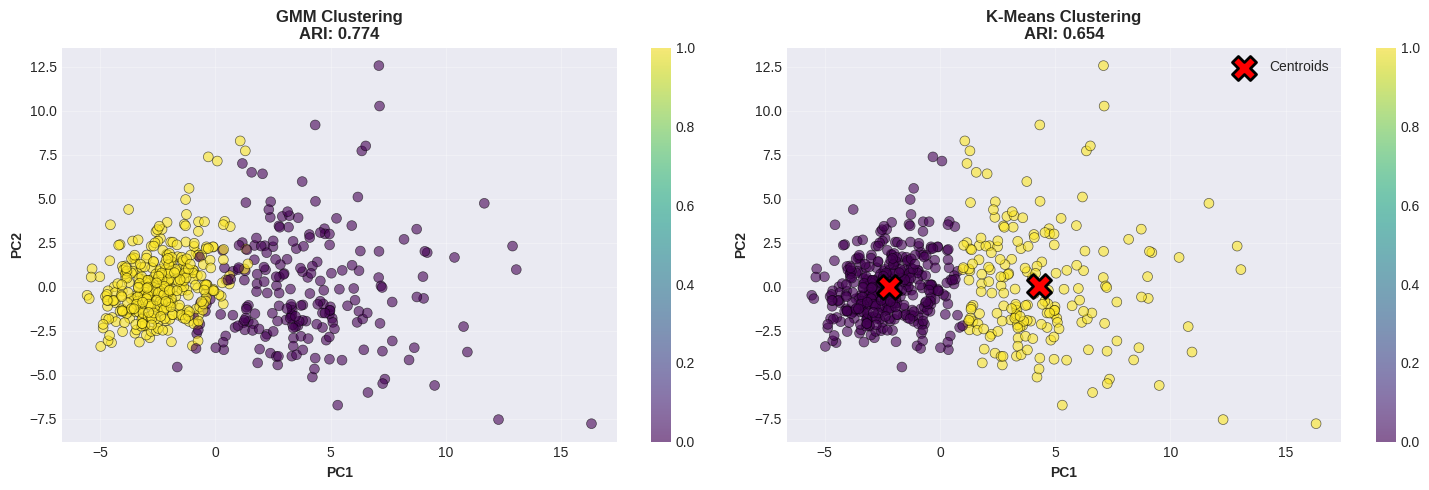


💡 Key Differences:
  • GMM provides probability estimates, K-Means gives hard assignments
  • GMM can model elliptical clusters, K-Means assumes spherical
  • GMM has model selection via BIC/AIC
  • K-Means is generally faster and simpler


In [14]:
from sklearn.cluster import KMeans

# Apply both algorithms to cancer data
kmeans_cancer = KMeans(n_clusters=2, random_state=42, n_init=10)
y_kmeans_cancer = kmeans_cancer.fit_predict(X_cancer_scaled)

# Compare metrics
comparison = pd.DataFrame({
    'Algorithm': ['GMM (full cov)', 'K-Means'],
    'Silhouette': [
        silhouette_score(X_cancer_scaled, y_pred_cancer),
        silhouette_score(X_cancer_scaled, y_kmeans_cancer)
    ],
    'Davies-Bouldin': [
        davies_bouldin_score(X_cancer_scaled, y_pred_cancer),
        davies_bouldin_score(X_cancer_scaled, y_kmeans_cancer)
    ],
    'ARI': [
        adjusted_rand_score(y_cancer, y_pred_cancer),
        adjusted_rand_score(y_cancer, y_kmeans_cancer)
    ],
    'NMI': [
        normalized_mutual_info_score(y_cancer, y_pred_cancer),
        normalized_mutual_info_score(y_cancer, y_kmeans_cancer)
    ]
})

print("="*70)
print("GMM VS K-MEANS COMPARISON - BREAST CANCER DATASET")
print("="*70)
display(comparison)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# GMM
scatter1 = axes[0].scatter(X_cancer_pca[:, 0], X_cancer_pca[:, 1],
                          c=y_pred_cancer, cmap='viridis',
                          s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'GMM Clustering\nARI: {adjusted_rand_score(y_cancer, y_pred_cancer):.3f}',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('PC1', fontweight='bold')
axes[0].set_ylabel('PC2', fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0])

# K-Means
scatter2 = axes[1].scatter(X_cancer_pca[:, 0], X_cancer_pca[:, 1],
                          c=y_kmeans_cancer, cmap='viridis',
                          s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
centroids_pca = pca.transform(kmeans_cancer.cluster_centers_)
axes[1].scatter(centroids_pca[:, 0], centroids_pca[:, 1],
               marker='X', s=300, c='red', edgecolors='black', linewidth=2, label='Centroids')
axes[1].set_title(f'K-Means Clustering\nARI: {adjusted_rand_score(y_cancer, y_kmeans_cancer):.3f}',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('PC1', fontweight='bold')
axes[1].set_ylabel('PC2', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

print("\n💡 Key Differences:")
print("  • GMM provides probability estimates, K-Means gives hard assignments")
print("  • GMM can model elliptical clusters, K-Means assumes spherical")
print("  • GMM has model selection via BIC/AIC")
print("  • K-Means is generally faster and simpler")

## 9. Summary and Key Takeaways

### What I Learned About GMM:

1. **Probabilistic Framework**: GMM is fundamentally different from K-Means because it's based on probability theory. Each cluster is a Gaussian distribution, and we model the data as a mixture of these distributions.

2. **Soft Clustering**: Instead of saying "this point belongs to cluster 1," GMM says "this point has 70% probability of belonging to cluster 1, 25% to cluster 2, and 5% to cluster 3." This is much more informative, especially for points near cluster boundaries!

3. **Flexibility with Covariance Types**:
   - **Full**: Most flexible, each cluster can have any shape/orientation
   - **Tied**: All clusters share the same shape
   - **Diag**: Clusters are axis-aligned ellipses
   - **Spherical**: Like K-Means, circular clusters

4. **Model Selection**: BIC and AIC provide principled ways to choose the number of clusters. This is a huge advantage over K-Means where we rely more on heuristics like the elbow method.

5. **Computational Cost**: GMM is more expensive than K-Means due to calculating and updating covariance matrices. For the breast cancer dataset (30 features, 569 samples), it was still very fast though.

### Performance Observations:

- On the breast cancer dataset, GMM performed comparably to K-Means in terms of metrics
- The soft clustering capability is really valuable - we can identify uncertain predictions
- Full covariance GMM captured the elliptical structure of clusters better than K-Means
- BIC suggested 2-3 components for most datasets, which aligned with the true number of classes

### Personal Reflections:

What really struck me about GMM is the additional information it provides beyond just cluster assignments. The probability estimates are invaluable - they tell you which predictions to trust and which are uncertain. In a medical context like breast cancer diagnosis, knowing "this sample is 95% likely benign" versus "this sample is 55% likely benign" makes a huge difference!

The covariance ellipses are also super helpful for visualization and understanding. You can see not just where the cluster centers are, but the shape and spread of each cluster. K-Means just gives you points and centroids.

However, I can see why K-Means remains popular - it's simpler, faster, and often "good enough." GMM shines when you need that extra modeling flexibility and probabilistic interpretation.

### When to Use GMM:

**Choose GMM when:**
- You want probabilistic cluster assignments
- Clusters have different shapes/sizes/orientations
- You need uncertainty estimates
- You want to use BIC/AIC for model selection
- Dataset is not too large (< 100k samples typically)

 **Choose K-Means when:**
- You need maximum speed
- Hard assignments are sufficient
- Clusters are roughly spherical
- Working with very large datasets

###  Key Technical Points:

- GMM uses the Expectation-Maximization (EM) algorithm
- E-step: Calculate probability of each point belonging to each cluster
- M-step: Update cluster parameters (means, covariances, weights)
- Like K-Means, can get stuck in local optima (run multiple times)
- Number of parameters grows quickly with full covariance: O(n_features²)

Overall, GMM is a powerful and elegant algorithm that extends K-Means with a solid probabilistic foundation. The ability to model different cluster shapes and provide uncertainty estimates makes it worth the extra computational cost in many applications!